# start

In [1]:
TGT='Reply'
PRFX='Reply0521A2'

trntmstmp=1584412344
tsttmstmp=1590075806

tm_trn_min,tm_trn_max=(1580947200, 1581551999)
tm_tst_min,tm_tst_max=(1581552000, 1582156799)

train_total=148075238
test_total=int(1.4e7)
print(f'train_total {train_total:,}, test_total {test_total:,}')

SEED=101

trnsz = int(1e7)
valsz = trnsz//10
print(f'train_total {trnsz:,}, valsz {valsz:,}')



import datetime
def showtm(tm): return datetime.datetime.fromtimestamp(tm).strftime('%Y-%m-%d %H:%M:%S')
print([showtm(tm) for tm in (trntmstmp, tsttmstmp)])
print([showtm(tm) for tm in (tm_trn_min,tm_trn_max)])
print([showtm(tm) for tm in (tm_tst_min,tm_tst_max)])

train_total 148,075,238, test_total 14,000,000
train_total 10,000,000, valsz 1,000,000
['2020-03-17 02:32:24', '2020-05-21 15:43:26']
['2020-02-06 00:00:00', '2020-02-12 23:59:59']
['2020-02-13 00:00:00', '2020-02-19 23:59:59']


# setup

In [2]:
from tqdm import tqdm
import time
from pathlib import Path
from collections import Counter,defaultdict
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
import pickle
# import xgboost as xgb
import lightgbm as lgb
import category_encoders as ce
import gc

import optuna
# optuna.logging.CRITICAL, optuna.logging.FATAL
# optuna.logging.ERROR
# optuna.logging.WARNING, optuna.logging.WARN
# optuna.logging.INFO
# optuna.logging.DEBUG
# optuna.logging.set_verbosity(optuna.logging.ERROR)
import optuna.integration.lightgbm as lgb
optuna.logging.disable_default_handler()


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

def iou(s1,s2):
    return len(s1&s2) / len(s1|s2)

HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

# https://towardsdatascience.com/how-to-calibrate-undersampled-model-scores-8f3319c1ea5b
# How to use the function?
# Let’s say your goal is to generate a model that shows the credit default probabilities and your original 
# training data has 50,000 rows with only 500 of them labeled as target class. When you sample your non-target 
# instances randomly and reduce the total row count to 10,000, while conserving 500 target rows, our calibration
# function becomes:
# calibration(model_results, 50000, 500, 10000, 500)
# Here model_results is your model probability output array. After you train your model and put the results in it, your function is ready to use. 
def calibration(data, train_pop, target_pop, sampled_train_pop, sampled_target_pop):
    calibrated_data = ((data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop)) /
    (((1 - data) * (1 - target_pop / train_pop) / (1 - sampled_target_pop / sampled_train_pop)) +
     (data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop))))
    return calibrated_data


cols=['toks','hshtgs','twtid','media','links','domns','twttyp','lang','tm','u1id','u1_fllwer_cnt','u1_fllwing_cnt','u1_vrfed','u1_create_tm','u2id','u2_fllwer_cnt','u2_fllwng_cnt','u2_vrfed','u2_create_tm','u1_fllw_u2','reply_tm','retwt_tm','retwt_cmmnt_tm','like_tm',]

cols_val = cols[:-4]
cols_tgt_tmstmp=[ 'retwt_tm', 'reply_tm', 'like_tm', 'retwt_cmmnt_tm',]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
tgt2col = dict(zip(tgts, cols_tgt))
TCOL=tgt2col[TGT]
print('TCOL', TCOL)
print(tgt2col)

TCOL reply
{'Retweet': 'retwt', 'Reply': 'reply', 'Like': 'like', 'RTwCmnt': 'retwt_cmmnt'}


# prep

In [3]:
def prp_tgt(df):
    df[cols_tgt]=df[cols_tgt_tmstmp].notna()
    df.drop(columns=cols_tgt_tmstmp, inplace=True)
    display(df[cols_tgt].mean())

In [4]:
%%time
dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=valsz)
print(dfval.shape)
prp_tgt(dfval)

(1000000, 24)


retwt          0.113135
reply          0.027688
like           0.438804
retwt_cmmnt    0.007750
dtype: float64

CPU times: user 11.2 s, sys: 1.36 s, total: 12.6 s
Wall time: 25.2 s


## maybe oversample

In [5]:
# df = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=5)
# dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=2)
# dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,skiprows=2,nrows=3)
# display(df.twtid)
# display(dfval.twtid)
# display(dftrn.twtid)

# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# 2    519078C7834E9642508F72A6C2D0F3B7
# 3    52AAE9E33EFAC8C478C57B31A9E31ED1
# 4    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object
# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# Name: twtid, dtype: object
# 0    519078C7834E9642508F72A6C2D0F3B7
# 1    52AAE9E33EFAC8C478C57B31A9E31ED1
# 2    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object

In [6]:
%%time
if TGT in ('Retweet','Like'): trnpop=trnsz
if TGT=='Reply': trnpop=trnsz*3.7
if TGT=='RTwCmnt': trnpop=trnsz*11.5
assert trnpop<train_total

dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,
                     skiprows=valsz, nrows=trnpop)
print(dftrn.shape)
prp_tgt(dftrn)

(37000000, 24)


retwt          0.113052
reply          0.027434
like           0.439190
retwt_cmmnt    0.007789
dtype: float64

CPU times: user 8min 11s, sys: 2min, total: 10min 12s
Wall time: 20min 56s


In [7]:
train_pop=len(dftrn)
sampled_train_pop=trnsz
idx_pos = np.where(dftrn[TCOL])[0]
target_pop=sampled_target_pop=len(idx_pos)
if TGT in ('Reply','RTwCmnt'):
    idx_neg0 = np.where(~dftrn[TCOL])[0]
    idx_neg = np.random.choice(idx_neg0, trnsz-len(idx_pos), replace=False)
    idx = np.concatenate([idx_pos,idx_neg])
    dftrn = dftrn.iloc[idx].copy()
print(dftrn.shape, dftrn[TCOL].mean())
print(train_pop, target_pop, sampled_train_pop, sampled_target_pop)

display(dftrn.head())
display(dftrn.columns)

(10000000, 24) 0.1015047
37000000 1015047 10000000 1015047


,toks,hshtgs,twtid,media,links,domns,twttyp,lang,tm,u1id,u1_fllwer_cnt,u1_fllwing_cnt,u1_vrfed,u1_create_tm,u2id,u2_fllwer_cnt,u2_fllwng_cnt,u2_vrfed,u2_create_tm,u1_fllw_u2,retwt,reply,like,retwt_cmmnt
11,101\t22734\t19540\t10393\t124\t76456\t22201\t1...,NaN,F11BD399C084D3035209F62EC72C0E6A,NaN,NaN,NaN,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581044002,CFF9C8C70792DC31C769F29CBFA2FEBE,972,811,False,1575970944,0DD2B48B86395C04C36C377F0F499CC4,741,736,False,1563093560,True,False,True,True,False
32,101\t100397\t11447\t119\t100397\t11447\t119\t1...,NaN,65AFF257ED64E9FA0428A761AA305287,NaN,NaN,NaN,Quote,1FFD2FE4297F5E70EBC6C3230D95CB9C,1581462579,5BA44B16761DE43723E20E995437805C,514,858,False,1237411551,0DD2CF17568371669DD5807061A7F231,17,38,False,1376576148,True,False,True,False,False
67,101\t232\t10113\t44730\t17828\t102,NaN,96D790B62A2C15769B830E3A3E51BF34,NaN,NaN,NaN,TopLevel,FA3F382BC409C271E3D6EAF8BE4648DD,1581374220,2111169D09C052121BDF329807DC75A4,5296,1088,False,1286175742,0DD2ED2C408A60972110349BC121AEA7,77,304,False,1369165590,False,False,True,False,False
84,101\t10862\t11710\t11223\t14517\t89106\t17021\...,NaN,46FB82A9A3034DDBD4A7C1E545720DF0,NaN,NaN,NaN,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581536890,F8742926680CE7BA15DA13CE557BE011,2234,416,False,1305458959,0DD2FD96A5F56E0ABA54276D3CCC7480,1178,1661,False,1349738202,False,False,True,False,False
118,101\t4726\t4997\t3740\t1931\t26164\t29570\t706...,NaN,9F3630A26084A55B8326376FC4AF5AF2,NaN,NaN,NaN,TopLevel,22C448FF81263D4BAF2A176145EE9EAD,1581463772,FE2B80E908ED0EF93CE0749BD93854BF,128,144,False,1567089785,0DD31F56720FD03FF243779A0004A4A8,146,191,False,1571151626,True,False,True,False,False


Index(['toks', 'hshtgs', 'twtid', 'media', 'links', 'domns', 'twttyp', 'lang',
       'tm', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt', 'u1_vrfed',
       'u1_create_tm', 'u2id', 'u2_fllwer_cnt', 'u2_fllwng_cnt', 'u2_vrfed',
       'u2_create_tm', 'u1_fllw_u2', 'retwt', 'reply', 'like', 'retwt_cmmnt'],
      dtype='object')

## prep and features

In [8]:
def prp_df(df, tm_max):
    '''
    tm_max = tm_trn_max for train tm_tst_max for test
    '''
    lendf = len(df)
    print(dtnow(), 'start')
    set_u1 = set(df.u1id)
    set_u2 = set(df.u2id)
    df['u1inu2']=df.u1id.isin(set_u2)
    df['u2inu1']=df.u2id.isin(set_u1)

    #counts
    df['len_toks'] = df.toks.apply(lambda x: len(x.split('\t')))
    df.drop(columns=['toks'], inplace=True)    
    for m in ['Photo', 'Video', 'GIF']:
        df[f'n_media_{m}'] = df['media'].fillna('').apply(lambda x: x.split('\t').count(m))
    tgnms = ['hshtgs','media', 'links', 'domns',]
    for tgnm in tgnms:
        df[f'has_{tgnm}']=df[tgnm].notna()
        df[f'lst_{tgnm}'] = df[tgnm].fillna('').apply(lambda x: x.split('\t') if len(x) else [])
        df[f'n_{tgnm}'] = df[f'lst_{tgnm}'].apply(len)  
    df.drop(columns=['has_links','n_links'], inplace=True) #duplicates has_domns,n_domns 
    
    #time
    dt = pd.to_datetime(df.tm, unit='s')
    df['dayofweek'] = dt.dt.dayofweek
    df['hour'] = dt.dt.hour
    
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    df['tmdlta_twtu1'] = df.tm - df.u1_create_tm
    df['tmdlta_twtu2'] = df.tm - df.u2_create_tm

    df['twt_age']   = tm_max-df.tm
    df['u1_age']    = tm_max-df.u1_create_tm
    df['u2_age']    = tm_max-df.u2_create_tm
    df.drop(columns=['tm', 'u1_create_tm', 'u2_create_tm'], inplace=True)

    #time derived
    df['u1_fllwer_cnt_by_age'] = df.u1_fllwer_cnt / df.u1_age
    df['u1_fllwng_cnt_by_age'] = df.u2_fllwng_cnt / df.u2_age
    
    #interaction
    df['u1u2']=df.u1id+'_'+df.u2id
    df['langhour']=df.lang+'_'+df.hour.astype(str)
    

#     #freq of feature values
#     print(dtnow(), 'freq of columns using CountEncoder')
#     encoder = ce.CountEncoder()
#     encoded = encoder.fit_transform(
#     df[['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwing_cnt', 'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_vrfed', 'u1_fllw_u2', 
#        'n_media_Photo', 'n_media_Video', 'n_media_GIF', 
#        'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media','has_domns', 'n_domns', 
#        'dayofweek', 'hour', 'u1u2', 'langhour']].astype(object))
#     encoded = encoded.astype(int)/lendf
#     encoded.columns = [f'frq_{col}' for col in encoded.columns]
#     df = pd.concat([df,encoded],1)
    
    #freq of tgnm values
#     print(dtnow(), 'freq of tags')
#     for tgnm in tgnms:
#         vs = [j for i in df[f'lst_{tgnm}'] for j in i]
#         cnt = Counter(vs)
#         frq = {k:v/lendf for k,v in cnt.items()}
#         df[f'sumfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: sum([frq.get(o,0) for o in x]))
#         df[f'maxfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: max([frq.get(o,0) for o in x]) if len(x) else 0)
    
    df.drop(columns=tgnms+[f'lst_{tgnm}' for tgnm in tgnms],inplace=True)

    print(dtnow(), 'done')
    return df

In [9]:
%%time
dftrn=prp_df(dftrn, tm_max=tm_trn_max)

2020-05-21 20:51:04 start
2020-05-21 21:11:38 done
CPU times: user 9min 49s, sys: 2min 12s, total: 12min 1s
Wall time: 20min 37s


In [10]:
%%time
dfval=prp_df(dfval, tm_max=tm_trn_max)

2020-05-21 21:11:41 start
2020-05-21 21:11:57 done
CPU times: user 14.1 s, sys: 2.26 s, total: 16.3 s
Wall time: 16.1 s


## tr vl split

In [11]:
msk_vl=np.random.rand(len(dftrn))<0.15
idxvl=np.where( msk_vl)[0]
idxtr=np.where(~msk_vl)[0]

dftr = dftrn.iloc[idxtr].copy()
dfvl = dftrn.iloc[idxvl].copy()
del dftrn

gc.collect()

30

In [12]:
cols_category=['twttyp', 'lang', 'langhour']
for df in dftr,dfvl,dfval:
    df.drop(columns=['twtid','u1id','u2id','u1u2'], inplace=True)
    df[cols_category]=df[cols_category].astype('category')

In [13]:
cols_feat = [col for col in dftr.columns if col not in cols_tgt]

# model

## cols_feat

In [14]:
cols_feat

['twttyp',
 'lang',
 'u1_fllwer_cnt',
 'u1_fllwing_cnt',
 'u1_vrfed',
 'u2_fllwer_cnt',
 'u2_fllwng_cnt',
 'u2_vrfed',
 'u1_fllw_u2',
 'u1inu2',
 'u2inu1',
 'len_toks',
 'n_media_Photo',
 'n_media_Video',
 'n_media_GIF',
 'has_hshtgs',
 'n_hshtgs',
 'has_media',
 'n_media',
 'has_domns',
 'n_domns',
 'dayofweek',
 'hour',
 'tmdlta_u2u1',
 'tmdlta_twtu1',
 'tmdlta_twtu2',
 'twt_age',
 'u1_age',
 'u2_age',
 'u1_fllwer_cnt_by_age',
 'u1_fllwng_cnt_by_age',
 'langhour']

In [15]:
print(len(cols_feat))


32


In [16]:
results = {}
results['PRFX'] = PRFX
results['TGT'] = TGT
results['cols_feat'] = cols_feat

In [17]:
params={
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': 0,    
}

results['params'] = params

In [ ]:
%%time
dtr = lgb.Dataset(dftr[cols_feat], label=dftr[TCOL])
dvl = lgb.Dataset(dfvl[cols_feat], label=dfvl[TCOL])
best_params, tuning_history = {}, []
evalres = {}
evallist = [(dtr, 'train'), (dvl, 'eval')]
bst = lgb.train(params=params, 
                train_set=dtr, 
                num_boost_round=50000,
                valid_sets=[dtr, dvl],
                valid_names=['tr','vl'],
                best_params=best_params,
                tuning_history=tuning_history,
                verbose_eval=100,
                early_stopping_rounds=100,
                evals_result=evalres,
               )
results['bst'] = bst
results['evalres'] = evalres
results['best_params']=best_params
results['tuning_history']=tuning_history

/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/optuna/_experimental.py:87: ExperimentalWarning: train is experimental (supported from v0.18.0). The interface can change in the future.
  ExperimentalWarning
tune_feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.279099	vl's binary_logloss: 0.279454
[200]	tr's binary_logloss: 0.277208	vl's binary_logloss: 0.278022
[300]	tr's binary_logloss: 0.276059	vl's binary_logloss: 0.277302
[400]	tr's binary_logloss: 0.275265	vl's binary_logloss: 0.276864
[500]	tr's binary_logloss: 0.274545	vl's binary_logloss: 0.276537
[600]	tr's binary_logloss: 0.273903	vl's binary_logloss: 0.276277
[700]	tr's binary_logloss: 0.273274	vl's binary_logloss: 0.276025
[800]	tr's binary_logloss: 0.272794	vl's binary_logloss: 0.275894
[900]	tr's binary_logloss: 0.272286	vl's binary_logloss: 0.275682
[1000]	tr's binary_logloss: 0.2718	vl's binary_logloss: 0.275525
[1100]	tr's binary_logloss: 0.271366	vl's binary_logloss: 0.275411
[1200]	tr's binary_logloss: 0.270929	vl's binary_logloss: 0.275272
[1300]	tr's binary_logloss: 0.27054	vl's binary_logloss: 0.275178
[1400]	tr's binary_logloss: 0.270149	vl's binary_logloss: 0.275089
[1500]	tr's 

tune_feature_fraction, val_score: 0.274075:  14%|#4        | 1/7 [43:47<4:22:44, 2627.38s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.278671	vl's binary_logloss: 0.279108
[200]	tr's binary_logloss: 0.276816	vl's binary_logloss: 0.277815
[300]	tr's binary_logloss: 0.275778	vl's binary_logloss: 0.277268
[400]	tr's binary_logloss: 0.274789	vl's binary_logloss: 0.276772
[500]	tr's binary_logloss: 0.274007	vl's binary_logloss: 0.276455
[600]	tr's binary_logloss: 0.273323	vl's binary_logloss: 0.276192
[700]	tr's binary_logloss: 0.272717	vl's binary_logloss: 0.275983
[800]	tr's binary_logloss: 0.272115	vl's binary_logloss: 0.275806
[900]	tr's binary_logloss: 0.271605	vl's binary_logloss: 0.275636
[1000]	tr's binary_logloss: 0.271149	vl's binary_logloss: 0.275545
[1100]	tr's binary_logloss: 0.270671	vl's binary_logloss: 0.275391
[1200]	tr's binary_logloss: 0.270229	vl's binary_logloss: 0.275299
[1300]	tr's binary_logloss: 0.269835	vl's binary_logloss: 0.275216
[1400]	tr's binary_logloss: 0.26942	vl's binary_logloss: 0.275131
[1500]	tr'

tune_feature_fraction, val_score: 0.274075:  29%|##8       | 2/7 [1:11:05<3:14:12, 2330.43s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.278643	vl's binary_logloss: 0.279109
[200]	tr's binary_logloss: 0.276692	vl's binary_logloss: 0.277831
[300]	tr's binary_logloss: 0.275667	vl's binary_logloss: 0.277278
[400]	tr's binary_logloss: 0.274674	vl's binary_logloss: 0.276826
[500]	tr's binary_logloss: 0.273857	vl's binary_logloss: 0.276472
[600]	tr's binary_logloss: 0.273158	vl's binary_logloss: 0.276176
[700]	tr's binary_logloss: 0.272586	vl's binary_logloss: 0.275993
[800]	tr's binary_logloss: 0.272003	vl's binary_logloss: 0.275833
[900]	tr's binary_logloss: 0.271422	vl's binary_logloss: 0.275677
[1000]	tr's binary_logloss: 0.270911	vl's binary_logloss: 0.275557
[1100]	tr's binary_logloss: 0.270381	vl's binary_logloss: 0.275428
[1200]	tr's binary_logloss: 0.269948	vl's binary_logloss: 0.275345
[1300]	tr's binary_logloss: 0.26949	vl's binary_logloss: 0.275254
[1400]	tr's binary_logloss: 0.269055	vl's binary_logloss: 0.275171
[1500]	tr'

tune_feature_fraction, val_score: 0.274075:  43%|####2     | 3/7 [1:26:39<2:07:26, 1911.57s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.278513	vl's binary_logloss: 0.27906
[200]	tr's binary_logloss: 0.276659	vl's binary_logloss: 0.277946
[300]	tr's binary_logloss: 0.275472	vl's binary_logloss: 0.277377
[400]	tr's binary_logloss: 0.274327	vl's binary_logloss: 0.276903
[500]	tr's binary_logloss: 0.273413	vl's binary_logloss: 0.27653
[600]	tr's binary_logloss: 0.27275	vl's binary_logloss: 0.276276
[700]	tr's binary_logloss: 0.272011	vl's binary_logloss: 0.27601
[800]	tr's binary_logloss: 0.271418	vl's binary_logloss: 0.275876
[900]	tr's binary_logloss: 0.270845	vl's binary_logloss: 0.275757
[1000]	tr's binary_logloss: 0.270309	vl's binary_logloss: 0.275656
[1100]	tr's binary_logloss: 0.269775	vl's binary_logloss: 0.275548
[1200]	tr's binary_logloss: 0.269196	vl's binary_logloss: 0.275432
[1300]	tr's binary_logloss: 0.268732	vl's binary_logloss: 0.275344
[1400]	tr's binary_logloss: 0.268261	vl's binary_logloss: 0.275276
[1500]	tr's b

tune_feature_fraction, val_score: 0.274075:  57%|#####7    | 4/7 [1:40:18<1:19:12, 1584.01s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.278421	vl's binary_logloss: 0.279059
[200]	tr's binary_logloss: 0.276448	vl's binary_logloss: 0.27796
[300]	tr's binary_logloss: 0.275223	vl's binary_logloss: 0.277377
[400]	tr's binary_logloss: 0.274167	vl's binary_logloss: 0.276996
[500]	tr's binary_logloss: 0.273331	vl's binary_logloss: 0.276696
[600]	tr's binary_logloss: 0.272486	vl's binary_logloss: 0.27648
[700]	tr's binary_logloss: 0.271773	vl's binary_logloss: 0.276271
[800]	tr's binary_logloss: 0.271119	vl's binary_logloss: 0.276128
[900]	tr's binary_logloss: 0.270419	vl's binary_logloss: 0.275968
[1000]	tr's binary_logloss: 0.269804	vl's binary_logloss: 0.275855
[1100]	tr's binary_logloss: 0.269269	vl's binary_logloss: 0.27578
[1200]	tr's binary_logloss: 0.268731	vl's binary_logloss: 0.275709
[1300]	tr's binary_logloss: 0.268231	vl's binary_logloss: 0.275645
[1400]	tr's binary_logloss: 0.267759	vl's binary_logloss: 0.275605
[1500]	tr's 

tune_feature_fraction, val_score: 0.274075:  71%|#######1  | 5/7 [1:51:00<43:22, 1301.15s/it]  

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.278326	vl's binary_logloss: 0.278992
[200]	tr's binary_logloss: 0.276274	vl's binary_logloss: 0.277925
[300]	tr's binary_logloss: 0.275085	vl's binary_logloss: 0.27744
[400]	tr's binary_logloss: 0.27399	vl's binary_logloss: 0.277041
[500]	tr's binary_logloss: 0.27317	vl's binary_logloss: 0.276802
[600]	tr's binary_logloss: 0.272405	vl's binary_logloss: 0.276605
[700]	tr's binary_logloss: 0.271683	vl's binary_logloss: 0.276432
[800]	tr's binary_logloss: 0.270989	vl's binary_logloss: 0.276296
[900]	tr's binary_logloss: 0.270282	vl's binary_logloss: 0.276121
[1000]	tr's binary_logloss: 0.269746	vl's binary_logloss: 0.27605
[1100]	tr's binary_logloss: 0.269122	vl's binary_logloss: 0.275948
[1200]	tr's binary_logloss: 0.268533	vl's binary_logloss: 0.27587
[1300]	tr's binary_logloss: 0.267993	vl's binary_logloss: 0.275797
[1400]	tr's binary_logloss: 0.267476	vl's binary_logloss: 0.275744
[1500]	tr's bi

tune_feature_fraction, val_score: 0.274075:  86%|########5 | 6/7 [2:00:54<18:09, 1089.11s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.27826	vl's binary_logloss: 0.278983
[200]	tr's binary_logloss: 0.276207	vl's binary_logloss: 0.277908
[300]	tr's binary_logloss: 0.275008	vl's binary_logloss: 0.277486
[400]	tr's binary_logloss: 0.273949	vl's binary_logloss: 0.277157
[500]	tr's binary_logloss: 0.272988	vl's binary_logloss: 0.276883
[600]	tr's binary_logloss: 0.272229	vl's binary_logloss: 0.276696
[700]	tr's binary_logloss: 0.271429	vl's binary_logloss: 0.276507
[800]	tr's binary_logloss: 0.270717	vl's binary_logloss: 0.276381
[900]	tr's binary_logloss: 0.270103	vl's binary_logloss: 0.276303
[1000]	tr's binary_logloss: 0.269446	vl's binary_logloss: 0.276205
[1100]	tr's binary_logloss: 0.2688	vl's binary_logloss: 0.276132
[1200]	tr's binary_logloss: 0.268201	vl's binary_logloss: 0.276041
[1300]	tr's binary_logloss: 0.267609	vl's binary_logloss: 0.275967
[1400]	tr's binary_logloss: 0.267103	vl's binary_logloss: 0.27591
[1500]	tr's b

tune_num_leaves, val_score: 0.274075:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.274841	vl's binary_logloss: 0.276703
[200]	tr's binary_logloss: 0.272265	vl's binary_logloss: 0.275567
[300]	tr's binary_logloss: 0.270701	vl's binary_logloss: 0.275286
[400]	tr's binary_logloss: 0.269154	vl's binary_logloss: 0.274931
[500]	tr's binary_logloss: 0.267839	vl's binary_logloss: 0.274666
[600]	tr's binary_logloss: 0.266588	vl's binary_logloss: 0.274451
[700]	tr's binary_logloss: 0.265395	vl's binary_logloss: 0.274343
[800]	tr's binary_logloss: 0.264249	vl's binary_logloss: 0.274263
[900]	tr's binary_logloss: 0.26313	vl's binary_logloss: 0.274167
[1000]	tr's binary_logloss: 0.262078	vl's binary_logloss: 0.274115
[1100]	tr's binary_logloss: 0.261041	vl's binary_logloss: 0.274041
[1200]	tr's binary_logloss: 0.260052	vl's binary_logloss: 0.274005
[1300]	tr's binary_logloss: 0.259049	vl's binary_logloss: 0.273958
[1400]	tr's binary_logloss: 0.258038	vl's binary_logloss: 0.273912
[1500]	tr'

tune_num_leaves, val_score: 0.273757:   5%|5         | 1/20 [09:51<3:07:12, 591.17s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.274688	vl's binary_logloss: 0.276641
[200]	tr's binary_logloss: 0.27212	vl's binary_logloss: 0.275456
[300]	tr's binary_logloss: 0.270445	vl's binary_logloss: 0.275003
[400]	tr's binary_logloss: 0.268993	vl's binary_logloss: 0.274757
[500]	tr's binary_logloss: 0.267674	vl's binary_logloss: 0.274556
[600]	tr's binary_logloss: 0.266431	vl's binary_logloss: 0.274355
[700]	tr's binary_logloss: 0.265198	vl's binary_logloss: 0.274232
[800]	tr's binary_logloss: 0.263972	vl's binary_logloss: 0.27411
[900]	tr's binary_logloss: 0.262817	vl's binary_logloss: 0.273991
[1000]	tr's binary_logloss: 0.261789	vl's binary_logloss: 0.273988
[1100]	tr's binary_logloss: 0.260735	vl's binary_logloss: 0.273951
[1200]	tr's binary_logloss: 0.259676	vl's binary_logloss: 0.273893
[1300]	tr's binary_logloss: 0.258634	vl's binary_logloss: 0.27384
[1400]	tr's binary_logloss: 0.257609	vl's binary_logloss: 0.273832
[1500]	tr's 

tune_num_leaves, val_score: 0.273689:  10%|#         | 2/20 [18:39<2:51:40, 572.28s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273069	vl's binary_logloss: 0.275916
[200]	tr's binary_logloss: 0.269953	vl's binary_logloss: 0.274822
[300]	tr's binary_logloss: 0.267759	vl's binary_logloss: 0.274435
[400]	tr's binary_logloss: 0.265792	vl's binary_logloss: 0.274217
[500]	tr's binary_logloss: 0.264004	vl's binary_logloss: 0.274057
[600]	tr's binary_logloss: 0.262281	vl's binary_logloss: 0.273968
[700]	tr's binary_logloss: 0.260765	vl's binary_logloss: 0.273915
[800]	tr's binary_logloss: 0.259098	vl's binary_logloss: 0.273869
[900]	tr's binary_logloss: 0.257762	vl's binary_logloss: 0.273837
[1000]	tr's binary_logloss: 0.256292	vl's binary_logloss: 0.273806
[1100]	tr's binary_logloss: 0.254915	vl's binary_logloss: 0.273789
[1200]	tr's binary_logloss: 0.253468	vl's binary_logloss: 0.273764
[1300]	tr's binary_logloss: 0.252113	vl's binary_logloss: 0.273748
[1400]	tr's binary_logloss: 0.250966	vl's binary_logloss: 0.273752
Early sto

tune_num_leaves, val_score: 0.273689:  15%|#5        | 3/20 [25:56<2:30:39, 531.71s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.275785	vl's binary_logloss: 0.277194
[200]	tr's binary_logloss: 0.273454	vl's binary_logloss: 0.276001
[300]	tr's binary_logloss: 0.271936	vl's binary_logloss: 0.275514
[400]	tr's binary_logloss: 0.270696	vl's binary_logloss: 0.275202
[500]	tr's binary_logloss: 0.269551	vl's binary_logloss: 0.274899
[600]	tr's binary_logloss: 0.268397	vl's binary_logloss: 0.274642
[700]	tr's binary_logloss: 0.267432	vl's binary_logloss: 0.27448
[800]	tr's binary_logloss: 0.266545	vl's binary_logloss: 0.274406
[900]	tr's binary_logloss: 0.265636	vl's binary_logloss: 0.274274
[1000]	tr's binary_logloss: 0.264768	vl's binary_logloss: 0.274247
[1100]	tr's binary_logloss: 0.263947	vl's binary_logloss: 0.274204
[1200]	tr's binary_logloss: 0.263106	vl's binary_logloss: 0.274126
[1300]	tr's binary_logloss: 0.262351	vl's binary_logloss: 0.274096
[1400]	tr's binary_logloss: 0.261572	vl's binary_logloss: 0.274057
[1500]	tr'

tune_num_leaves, val_score: 0.273689:  20%|##        | 4/20 [35:34<2:25:29, 545.61s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.274447	vl's binary_logloss: 0.276529
[200]	tr's binary_logloss: 0.271815	vl's binary_logloss: 0.275378
[300]	tr's binary_logloss: 0.270072	vl's binary_logloss: 0.274991
[400]	tr's binary_logloss: 0.268446	vl's binary_logloss: 0.274657
[500]	tr's binary_logloss: 0.267026	vl's binary_logloss: 0.274456
[600]	tr's binary_logloss: 0.265699	vl's binary_logloss: 0.274292
[700]	tr's binary_logloss: 0.264465	vl's binary_logloss: 0.274192
[800]	tr's binary_logloss: 0.263218	vl's binary_logloss: 0.274081
[900]	tr's binary_logloss: 0.262012	vl's binary_logloss: 0.273971
[1000]	tr's binary_logloss: 0.261041	vl's binary_logloss: 0.273961
[1100]	tr's binary_logloss: 0.260091	vl's binary_logloss: 0.273936
[1200]	tr's binary_logloss: 0.259098	vl's binary_logloss: 0.27388
[1300]	tr's binary_logloss: 0.257933	vl's binary_logloss: 0.2738
[1400]	tr's binary_logloss: 0.256877	vl's binary_logloss: 0.273762
[1500]	tr's 

tune_num_leaves, val_score: 0.273689:  25%|##5       | 5/20 [44:37<2:16:10, 544.71s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.274168	vl's binary_logloss: 0.276391
[200]	tr's binary_logloss: 0.271541	vl's binary_logloss: 0.275301
[300]	tr's binary_logloss: 0.269739	vl's binary_logloss: 0.274864
[400]	tr's binary_logloss: 0.268115	vl's binary_logloss: 0.274563
[500]	tr's binary_logloss: 0.266609	vl's binary_logloss: 0.274383
[600]	tr's binary_logloss: 0.265168	vl's binary_logloss: 0.274199
[700]	tr's binary_logloss: 0.263968	vl's binary_logloss: 0.274149
[800]	tr's binary_logloss: 0.26269	vl's binary_logloss: 0.27408
[900]	tr's binary_logloss: 0.261437	vl's binary_logloss: 0.274032
[1000]	tr's binary_logloss: 0.260224	vl's binary_logloss: 0.274003
[1100]	tr's binary_logloss: 0.259056	vl's binary_logloss: 0.273953
[1200]	tr's binary_logloss: 0.257952	vl's binary_logloss: 0.273946
Early stopping, best iteration is:
[1168]	tr's binary_logloss: 0.2583	vl's binary_logloss: 0.273941


tune_num_leaves, val_score: 0.273689:  30%|###       | 6/20 [52:24<2:01:40, 521.49s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.276416	vl's binary_logloss: 0.277584
[200]	tr's binary_logloss: 0.274149	vl's binary_logloss: 0.276317
[300]	tr's binary_logloss: 0.272798	vl's binary_logloss: 0.275832
[400]	tr's binary_logloss: 0.271533	vl's binary_logloss: 0.275383
[500]	tr's binary_logloss: 0.270548	vl's binary_logloss: 0.275092
[600]	tr's binary_logloss: 0.269625	vl's binary_logloss: 0.274881
[700]	tr's binary_logloss: 0.268731	vl's binary_logloss: 0.274705
[800]	tr's binary_logloss: 0.26788	vl's binary_logloss: 0.274593
[900]	tr's binary_logloss: 0.267061	vl's binary_logloss: 0.274459
[1000]	tr's binary_logloss: 0.266358	vl's binary_logloss: 0.274402
[1100]	tr's binary_logloss: 0.265618	vl's binary_logloss: 0.274321
[1200]	tr's binary_logloss: 0.264875	vl's binary_logloss: 0.274233
[1300]	tr's binary_logloss: 0.264166	vl's binary_logloss: 0.274138
[1400]	tr's binary_logloss: 0.263502	vl's binary_logloss: 0.274096
[1500]	tr'

tune_num_leaves, val_score: 0.273689:  35%|###5      | 7/20 [1:01:51<1:55:54, 534.99s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.27224	vl's binary_logloss: 0.27561
[200]	tr's binary_logloss: 0.269009	vl's binary_logloss: 0.274814
[300]	tr's binary_logloss: 0.26663	vl's binary_logloss: 0.274487
[400]	tr's binary_logloss: 0.264359	vl's binary_logloss: 0.274224
[500]	tr's binary_logloss: 0.262194	vl's binary_logloss: 0.273981
[600]	tr's binary_logloss: 0.26035	vl's binary_logloss: 0.273865
[700]	tr's binary_logloss: 0.258538	vl's binary_logloss: 0.273816
[800]	tr's binary_logloss: 0.256788	vl's binary_logloss: 0.273794
[900]	tr's binary_logloss: 0.255127	vl's binary_logloss: 0.273737
[1000]	tr's binary_logloss: 0.253458	vl's binary_logloss: 0.273735
[1100]	tr's binary_logloss: 0.251995	vl's binary_logloss: 0.273743
Early stopping, best iteration is:
[1021]	tr's binary_logloss: 0.253078	vl's binary_logloss: 0.273716


tune_num_leaves, val_score: 0.273689:  40%|####      | 8/20 [1:09:16<1:41:37, 508.15s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.275603	vl's binary_logloss: 0.277097
[200]	tr's binary_logloss: 0.273342	vl's binary_logloss: 0.275971
[300]	tr's binary_logloss: 0.27173	vl's binary_logloss: 0.275435
[400]	tr's binary_logloss: 0.2704	vl's binary_logloss: 0.275076
[500]	tr's binary_logloss: 0.269233	vl's binary_logloss: 0.274816
[600]	tr's binary_logloss: 0.268125	vl's binary_logloss: 0.274622
[700]	tr's binary_logloss: 0.267239	vl's binary_logloss: 0.274509
[800]	tr's binary_logloss: 0.266214	vl's binary_logloss: 0.274435
[900]	tr's binary_logloss: 0.265286	vl's binary_logloss: 0.274313
[1000]	tr's binary_logloss: 0.264374	vl's binary_logloss: 0.274242
[1100]	tr's binary_logloss: 0.263501	vl's binary_logloss: 0.274166
[1200]	tr's binary_logloss: 0.26263	vl's binary_logloss: 0.274118
[1300]	tr's binary_logloss: 0.261788	vl's binary_logloss: 0.274062
[1400]	tr's binary_logloss: 0.260981	vl's binary_logloss: 0.274005
Early stoppin

tune_num_leaves, val_score: 0.273689:  45%|####5     | 9/20 [1:17:45<1:33:11, 508.34s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.285601	vl's binary_logloss: 0.285469
[200]	tr's binary_logloss: 0.283933	vl's binary_logloss: 0.283814
[300]	tr's binary_logloss: 0.28312	vl's binary_logloss: 0.283043
[400]	tr's binary_logloss: 0.282373	vl's binary_logloss: 0.282347
[500]	tr's binary_logloss: 0.281785	vl's binary_logloss: 0.2818
[600]	tr's binary_logloss: 0.281257	vl's binary_logloss: 0.281324
[700]	tr's binary_logloss: 0.280905	vl's binary_logloss: 0.28102
[800]	tr's binary_logloss: 0.280501	vl's binary_logloss: 0.280666
[900]	tr's binary_logloss: 0.280173	vl's binary_logloss: 0.280383
[1000]	tr's binary_logloss: 0.279949	vl's binary_logloss: 0.28021
[1100]	tr's binary_logloss: 0.279701	vl's binary_logloss: 0.279998
[1200]	tr's binary_logloss: 0.279472	vl's binary_logloss: 0.279818
[1300]	tr's binary_logloss: 0.279293	vl's binary_logloss: 0.279676
[1400]	tr's binary_logloss: 0.279135	vl's binary_logloss: 0.279551
[1500]	tr's bi

tune_num_leaves, val_score: 0.273689:  50%|#####     | 10/20 [4:37:30<10:58:32, 3951.25s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.280473	vl's binary_logloss: 0.280581
[200]	tr's binary_logloss: 0.278702	vl's binary_logloss: 0.27909
[300]	tr's binary_logloss: 0.277692	vl's binary_logloss: 0.278372
[400]	tr's binary_logloss: 0.276946	vl's binary_logloss: 0.277861
[500]	tr's binary_logloss: 0.276352	vl's binary_logloss: 0.277504
[600]	tr's binary_logloss: 0.275823	vl's binary_logloss: 0.277233
[700]	tr's binary_logloss: 0.275339	vl's binary_logloss: 0.276987
[800]	tr's binary_logloss: 0.274954	vl's binary_logloss: 0.276816
[900]	tr's binary_logloss: 0.274562	vl's binary_logloss: 0.276617
[1000]	tr's binary_logloss: 0.274185	vl's binary_logloss: 0.276447
[1100]	tr's binary_logloss: 0.273825	vl's binary_logloss: 0.276296
[1200]	tr's binary_logloss: 0.273492	vl's binary_logloss: 0.276163
[1300]	tr's binary_logloss: 0.273172	vl's binary_logloss: 0.276009
[1400]	tr's binary_logloss: 0.272903	vl's binary_logloss: 0.275907
[1500]	tr'

tune_num_leaves, val_score: 0.273689:  55%|#####5    | 11/20 [6:10:40<11:06:26, 4442.99s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273691	vl's binary_logloss: 0.27618
[200]	tr's binary_logloss: 0.27088	vl's binary_logloss: 0.275151
[300]	tr's binary_logloss: 0.26901	vl's binary_logloss: 0.274781
[400]	tr's binary_logloss: 0.267063	vl's binary_logloss: 0.274425
[500]	tr's binary_logloss: 0.265314	vl's binary_logloss: 0.274187
[600]	tr's binary_logloss: 0.263764	vl's binary_logloss: 0.274082
[700]	tr's binary_logloss: 0.262269	vl's binary_logloss: 0.273998
[800]	tr's binary_logloss: 0.260895	vl's binary_logloss: 0.273918
[900]	tr's binary_logloss: 0.259635	vl's binary_logloss: 0.273889
[1000]	tr's binary_logloss: 0.258265	vl's binary_logloss: 0.27388
[1100]	tr's binary_logloss: 0.256978	vl's binary_logloss: 0.273862
[1200]	tr's binary_logloss: 0.255722	vl's binary_logloss: 0.273825
[1300]	tr's binary_logloss: 0.254476	vl's binary_logloss: 0.273794
[1400]	tr's binary_logloss: 0.253456	vl's binary_logloss: 0.27382
Early stopping

tune_num_leaves, val_score: 0.273689:  60%|######    | 12/20 [6:59:35<8:52:04, 3990.56s/it] 

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.272846	vl's binary_logloss: 0.275845
[200]	tr's binary_logloss: 0.269933	vl's binary_logloss: 0.274983
[300]	tr's binary_logloss: 0.267858	vl's binary_logloss: 0.274678
[400]	tr's binary_logloss: 0.265625	vl's binary_logloss: 0.274248
[500]	tr's binary_logloss: 0.263705	vl's binary_logloss: 0.274053
[600]	tr's binary_logloss: 0.262018	vl's binary_logloss: 0.273945
[700]	tr's binary_logloss: 0.260499	vl's binary_logloss: 0.273945
[800]	tr's binary_logloss: 0.258781	vl's binary_logloss: 0.273867
[900]	tr's binary_logloss: 0.257201	vl's binary_logloss: 0.273791
[1000]	tr's binary_logloss: 0.255694	vl's binary_logloss: 0.273753
[1100]	tr's binary_logloss: 0.254393	vl's binary_logloss: 0.273741
Early stopping, best iteration is:
[1056]	tr's binary_logloss: 0.254897	vl's binary_logloss: 0.27372


tune_num_leaves, val_score: 0.273689:  65%|######5   | 13/20 [7:46:54<7:05:15, 3645.02s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.277351	vl's binary_logloss: 0.278168
[200]	tr's binary_logloss: 0.275317	vl's binary_logloss: 0.276847
[300]	tr's binary_logloss: 0.274144	vl's binary_logloss: 0.276327
[400]	tr's binary_logloss: 0.273067	vl's binary_logloss: 0.275859
[500]	tr's binary_logloss: 0.272213	vl's binary_logloss: 0.275622
[600]	tr's binary_logloss: 0.271419	vl's binary_logloss: 0.275409
[700]	tr's binary_logloss: 0.270689	vl's binary_logloss: 0.275221
[800]	tr's binary_logloss: 0.270034	vl's binary_logloss: 0.2751
[900]	tr's binary_logloss: 0.2693	vl's binary_logloss: 0.274909
[1000]	tr's binary_logloss: 0.268687	vl's binary_logloss: 0.27482
[1100]	tr's binary_logloss: 0.268078	vl's binary_logloss: 0.274707
[1200]	tr's binary_logloss: 0.267467	vl's binary_logloss: 0.274574
[1300]	tr's binary_logloss: 0.266852	vl's binary_logloss: 0.274446
[1400]	tr's binary_logloss: 0.266271	vl's binary_logloss: 0.274334
[1500]	tr's bi

tune_num_leaves, val_score: 0.273689:  70%|#######   | 14/20 [9:02:57<6:32:02, 3920.45s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.274335	vl's binary_logloss: 0.276449
[200]	tr's binary_logloss: 0.271664	vl's binary_logloss: 0.275375
[300]	tr's binary_logloss: 0.269888	vl's binary_logloss: 0.274957
[400]	tr's binary_logloss: 0.268227	vl's binary_logloss: 0.274603
[500]	tr's binary_logloss: 0.266818	vl's binary_logloss: 0.274395
[600]	tr's binary_logloss: 0.265356	vl's binary_logloss: 0.274224
[700]	tr's binary_logloss: 0.264015	vl's binary_logloss: 0.274108
[800]	tr's binary_logloss: 0.262874	vl's binary_logloss: 0.274068
[900]	tr's binary_logloss: 0.261689	vl's binary_logloss: 0.273991
[1000]	tr's binary_logloss: 0.260546	vl's binary_logloss: 0.273941
[1100]	tr's binary_logloss: 0.259408	vl's binary_logloss: 0.273887
[1200]	tr's binary_logloss: 0.258264	vl's binary_logloss: 0.273828
[1300]	tr's binary_logloss: 0.257173	vl's binary_logloss: 0.273805
[1400]	tr's binary_logloss: 0.256154	vl's binary_logloss: 0.273777
[1500]	tr

tune_num_leaves, val_score: 0.273689:  75%|#######5  | 15/20 [10:03:05<5:18:54, 3826.85s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.274821	vl's binary_logloss: 0.276699
[200]	tr's binary_logloss: 0.272276	vl's binary_logloss: 0.275645
[300]	tr's binary_logloss: 0.270506	vl's binary_logloss: 0.275185
[400]	tr's binary_logloss: 0.269046	vl's binary_logloss: 0.274886
[500]	tr's binary_logloss: 0.267844	vl's binary_logloss: 0.274689
[600]	tr's binary_logloss: 0.266683	vl's binary_logloss: 0.274534
[700]	tr's binary_logloss: 0.26545	vl's binary_logloss: 0.274336
[800]	tr's binary_logloss: 0.264307	vl's binary_logloss: 0.274263
[900]	tr's binary_logloss: 0.263266	vl's binary_logloss: 0.274177
[1000]	tr's binary_logloss: 0.262195	vl's binary_logloss: 0.274134
[1100]	tr's binary_logloss: 0.261109	vl's binary_logloss: 0.274034
[1200]	tr's binary_logloss: 0.260043	vl's binary_logloss: 0.273941
[1300]	tr's binary_logloss: 0.259011	vl's binary_logloss: 0.273852
[1400]	tr's binary_logloss: 0.258152	vl's binary_logloss: 0.273844
[1500]	tr'

tune_num_leaves, val_score: 0.273689:  80%|########  | 16/20 [11:06:16<4:14:24, 3816.08s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273612	vl's binary_logloss: 0.276132
[200]	tr's binary_logloss: 0.27092	vl's binary_logloss: 0.275184
[300]	tr's binary_logloss: 0.268831	vl's binary_logloss: 0.274729
[400]	tr's binary_logloss: 0.267027	vl's binary_logloss: 0.274397
[500]	tr's binary_logloss: 0.265341	vl's binary_logloss: 0.274143
[600]	tr's binary_logloss: 0.263791	vl's binary_logloss: 0.274055
[700]	tr's binary_logloss: 0.26237	vl's binary_logloss: 0.274013
[800]	tr's binary_logloss: 0.261087	vl's binary_logloss: 0.273908
[900]	tr's binary_logloss: 0.259831	vl's binary_logloss: 0.273895
Early stopping, best iteration is:
[868]	tr's binary_logloss: 0.260213	vl's binary_logloss: 0.27388


tune_num_leaves, val_score: 0.273689:  85%|########5 | 17/20 [11:46:45<2:49:59, 3399.68s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.278353	vl's binary_logloss: 0.278869
[200]	tr's binary_logloss: 0.276462	vl's binary_logloss: 0.277553
[300]	tr's binary_logloss: 0.27525	vl's binary_logloss: 0.276891
[400]	tr's binary_logloss: 0.274354	vl's binary_logloss: 0.276462
[500]	tr's binary_logloss: 0.273597	vl's binary_logloss: 0.276189
[600]	tr's binary_logloss: 0.272889	vl's binary_logloss: 0.275932
[700]	tr's binary_logloss: 0.272313	vl's binary_logloss: 0.275756
[800]	tr's binary_logloss: 0.271644	vl's binary_logloss: 0.275552
[900]	tr's binary_logloss: 0.271081	vl's binary_logloss: 0.275396
[1000]	tr's binary_logloss: 0.270592	vl's binary_logloss: 0.275278
[1100]	tr's binary_logloss: 0.270039	vl's binary_logloss: 0.275118
[1200]	tr's binary_logloss: 0.269568	vl's binary_logloss: 0.275023
[1300]	tr's binary_logloss: 0.269087	vl's binary_logloss: 0.27491
[1400]	tr's binary_logloss: 0.268642	vl's binary_logloss: 0.274828
[1500]	tr's

tune_num_leaves, val_score: 0.273689:  90%|######### | 18/20 [13:23:38<2:17:27, 4123.68s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.275355	vl's binary_logloss: 0.276972
[200]	tr's binary_logloss: 0.272966	vl's binary_logloss: 0.275822
[300]	tr's binary_logloss: 0.271298	vl's binary_logloss: 0.275336
[400]	tr's binary_logloss: 0.269971	vl's binary_logloss: 0.275004
[500]	tr's binary_logloss: 0.268735	vl's binary_logloss: 0.274769
[600]	tr's binary_logloss: 0.267573	vl's binary_logloss: 0.274573
[700]	tr's binary_logloss: 0.266509	vl's binary_logloss: 0.274433
[800]	tr's binary_logloss: 0.265492	vl's binary_logloss: 0.274326
[900]	tr's binary_logloss: 0.26449	vl's binary_logloss: 0.274182
[1000]	tr's binary_logloss: 0.2635	vl's binary_logloss: 0.274098
[1100]	tr's binary_logloss: 0.26259	vl's binary_logloss: 0.274034
[1200]	tr's binary_logloss: 0.261697	vl's binary_logloss: 0.273942
[1300]	tr's binary_logloss: 0.260808	vl's binary_logloss: 0.273897
[1400]	tr's binary_logloss: 0.259991	vl's binary_logloss: 0.273874
[1500]	tr's b

tune_num_leaves, val_score: 0.273689:  95%|#########5| 19/20 [14:19:48<1:04:57, 3897.83s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273774	vl's binary_logloss: 0.276238
[200]	tr's binary_logloss: 0.270914	vl's binary_logloss: 0.275143
[300]	tr's binary_logloss: 0.269081	vl's binary_logloss: 0.274791
[400]	tr's binary_logloss: 0.267235	vl's binary_logloss: 0.274362
[500]	tr's binary_logloss: 0.26573	vl's binary_logloss: 0.274183
[600]	tr's binary_logloss: 0.264109	vl's binary_logloss: 0.274042
[700]	tr's binary_logloss: 0.262615	vl's binary_logloss: 0.273973
[800]	tr's binary_logloss: 0.261306	vl's binary_logloss: 0.273918
[900]	tr's binary_logloss: 0.260092	vl's binary_logloss: 0.273858
[1000]	tr's binary_logloss: 0.258721	vl's binary_logloss: 0.27384
[1100]	tr's binary_logloss: 0.257565	vl's binary_logloss: 0.273815
[1200]	tr's binary_logloss: 0.256361	vl's binary_logloss: 0.273802
[1300]	tr's binary_logloss: 0.255218	vl's binary_logloss: 0.273783
[1400]	tr's binary_logloss: 0.254069	vl's binary_logloss: 0.273754
[1500]	tr's

tune_num_leaves, val_score: 0.273683: 100%|##########| 20/20 [15:23:56<00:00, 2771.84s/it]  
tune_bagging_fraction_and_bagging_freq, val_score: 0.273683:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.274578	vl's binary_logloss: 0.276695
[200]	tr's binary_logloss: 0.271916	vl's binary_logloss: 0.275633
[300]	tr's binary_logloss: 0.270003	vl's binary_logloss: 0.275301
[400]	tr's binary_logloss: 0.268308	vl's binary_logloss: 0.27513
[500]	tr's binary_logloss: 0.266793	vl's binary_logloss: 0.275068
[600]	tr's binary_logloss: 0.26529	vl's binary_logloss: 0.275013
[700]	tr's binary_logloss: 0.263849	vl's binary_logloss: 0.274987
[800]	tr's binary_logloss: 0.262451	vl's binary_logloss: 0.275035
Early stopping, best iteration is:
[734]	tr's binary_logloss: 0.263346	vl's binary_logloss: 0.274981


tune_bagging_fraction_and_bagging_freq, val_score: 0.273683:  10%|#         | 1/10 [36:29<5:28:23, 2189.31s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273896	vl's binary_logloss: 0.276255
[200]	tr's binary_logloss: 0.271217	vl's binary_logloss: 0.275262
[300]	tr's binary_logloss: 0.269367	vl's binary_logloss: 0.274881
[400]	tr's binary_logloss: 0.267757	vl's binary_logloss: 0.274698
[500]	tr's binary_logloss: 0.266241	vl's binary_logloss: 0.27457
[600]	tr's binary_logloss: 0.26483	vl's binary_logloss: 0.274527
[700]	tr's binary_logloss: 0.263433	vl's binary_logloss: 0.274471
[800]	tr's binary_logloss: 0.26202	vl's binary_logloss: 0.274397
[900]	tr's binary_logloss: 0.26068	vl's binary_logloss: 0.274294
[1000]	tr's binary_logloss: 0.259336	vl's binary_logloss: 0.274241
[1100]	tr's binary_logloss: 0.25804	vl's binary_logloss: 0.274161
[1200]	tr's binary_logloss: 0.256769	vl's binary_logloss: 0.274102
[1300]	tr's binary_logloss: 0.255542	vl's binary_logloss: 0.2741
Early stopping, best iteration is:
[1225]	tr's binary_logloss: 0.256444	vl's binary

tune_bagging_fraction_and_bagging_freq, val_score: 0.273683:  20%|##        | 2/10 [1:32:22<5:38:27, 2538.38s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273986	vl's binary_logloss: 0.276274
[200]	tr's binary_logloss: 0.271281	vl's binary_logloss: 0.27527
[300]	tr's binary_logloss: 0.269417	vl's binary_logloss: 0.274929
[400]	tr's binary_logloss: 0.267719	vl's binary_logloss: 0.274719
[500]	tr's binary_logloss: 0.26614	vl's binary_logloss: 0.27459
[600]	tr's binary_logloss: 0.264615	vl's binary_logloss: 0.274468
[700]	tr's binary_logloss: 0.263161	vl's binary_logloss: 0.274365
[800]	tr's binary_logloss: 0.261774	vl's binary_logloss: 0.274359
[900]	tr's binary_logloss: 0.260393	vl's binary_logloss: 0.274318
[1000]	tr's binary_logloss: 0.259086	vl's binary_logloss: 0.274292
[1100]	tr's binary_logloss: 0.257734	vl's binary_logloss: 0.274223
[1200]	tr's binary_logloss: 0.256438	vl's binary_logloss: 0.2742
[1300]	tr's binary_logloss: 0.255202	vl's binary_logloss: 0.27422
Early stopping, best iteration is:
[1223]	tr's binary_logloss: 0.256129	vl's binar

tune_bagging_fraction_and_bagging_freq, val_score: 0.273683:  30%|###       | 3/10 [2:36:41<5:42:21, 2934.48s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.274251	vl's binary_logloss: 0.276497
[200]	tr's binary_logloss: 0.271561	vl's binary_logloss: 0.275427
[300]	tr's binary_logloss: 0.269712	vl's binary_logloss: 0.275133
[400]	tr's binary_logloss: 0.26793	vl's binary_logloss: 0.27484
[500]	tr's binary_logloss: 0.266369	vl's binary_logloss: 0.274712
[600]	tr's binary_logloss: 0.264873	vl's binary_logloss: 0.274649
[700]	tr's binary_logloss: 0.263459	vl's binary_logloss: 0.274621
[800]	tr's binary_logloss: 0.262053	vl's binary_logloss: 0.274585
[900]	tr's binary_logloss: 0.260668	vl's binary_logloss: 0.274537
Early stopping, best iteration is:
[885]	tr's binary_logloss: 0.260862	vl's binary_logloss: 0.274535


tune_bagging_fraction_and_bagging_freq, val_score: 0.273683:  40%|####      | 4/10 [3:20:04<4:43:30, 2835.06s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.274316	vl's binary_logloss: 0.276509
[200]	tr's binary_logloss: 0.27169	vl's binary_logloss: 0.275462
[300]	tr's binary_logloss: 0.269787	vl's binary_logloss: 0.27507
[400]	tr's binary_logloss: 0.26805	vl's binary_logloss: 0.274829
[500]	tr's binary_logloss: 0.266494	vl's binary_logloss: 0.274722
[600]	tr's binary_logloss: 0.26498	vl's binary_logloss: 0.274646
[700]	tr's binary_logloss: 0.263484	vl's binary_logloss: 0.274541
[800]	tr's binary_logloss: 0.262075	vl's binary_logloss: 0.274512
Early stopping, best iteration is:
[739]	tr's binary_logloss: 0.262904	vl's binary_logloss: 0.274493


tune_bagging_fraction_and_bagging_freq, val_score: 0.273683:  50%|#####     | 5/10 [3:57:54<3:42:08, 2665.63s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273842	vl's binary_logloss: 0.276237
[200]	tr's binary_logloss: 0.271129	vl's binary_logloss: 0.27523
[300]	tr's binary_logloss: 0.269335	vl's binary_logloss: 0.274917
[400]	tr's binary_logloss: 0.267679	vl's binary_logloss: 0.274689
[500]	tr's binary_logloss: 0.266186	vl's binary_logloss: 0.274567
[600]	tr's binary_logloss: 0.264731	vl's binary_logloss: 0.274466
[700]	tr's binary_logloss: 0.263317	vl's binary_logloss: 0.274387
[800]	tr's binary_logloss: 0.261906	vl's binary_logloss: 0.27429
[900]	tr's binary_logloss: 0.260521	vl's binary_logloss: 0.27419
[1000]	tr's binary_logloss: 0.25923	vl's binary_logloss: 0.27416
[1100]	tr's binary_logloss: 0.258	vl's binary_logloss: 0.274137
[1200]	tr's binary_logloss: 0.256729	vl's binary_logloss: 0.274102
[1300]	tr's binary_logloss: 0.255463	vl's binary_logloss: 0.27408
[1400]	tr's binary_logloss: 0.254215	vl's binary_logloss: 0.274072
[1500]	tr's binary

tune_bagging_fraction_and_bagging_freq, val_score: 0.273683:  60%|######    | 6/10 [5:06:37<3:26:51, 3103.00s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273881	vl's binary_logloss: 0.276254
[200]	tr's binary_logloss: 0.271111	vl's binary_logloss: 0.275193
[300]	tr's binary_logloss: 0.269308	vl's binary_logloss: 0.274861
[400]	tr's binary_logloss: 0.267646	vl's binary_logloss: 0.274545
[500]	tr's binary_logloss: 0.266134	vl's binary_logloss: 0.274349
[600]	tr's binary_logloss: 0.264759	vl's binary_logloss: 0.27427
[700]	tr's binary_logloss: 0.263407	vl's binary_logloss: 0.274205
[800]	tr's binary_logloss: 0.2621	vl's binary_logloss: 0.274139
[900]	tr's binary_logloss: 0.260843	vl's binary_logloss: 0.27409
[1000]	tr's binary_logloss: 0.259595	vl's binary_logloss: 0.274056
[1100]	tr's binary_logloss: 0.258378	vl's binary_logloss: 0.273999
[1200]	tr's binary_logloss: 0.257203	vl's binary_logloss: 0.273995
[1300]	tr's binary_logloss: 0.255987	vl's binary_logloss: 0.273944
[1400]	tr's binary_logloss: 0.254814	vl's binary_logloss: 0.273917
[1500]	tr's b

tune_bagging_fraction_and_bagging_freq, val_score: 0.273683:  70%|#######   | 7/10 [6:05:07<2:41:14, 3224.68s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273801	vl's binary_logloss: 0.276244
[200]	tr's binary_logloss: 0.270984	vl's binary_logloss: 0.275172
[300]	tr's binary_logloss: 0.269151	vl's binary_logloss: 0.274761
[400]	tr's binary_logloss: 0.267621	vl's binary_logloss: 0.274614
[500]	tr's binary_logloss: 0.266149	vl's binary_logloss: 0.274444
[600]	tr's binary_logloss: 0.264751	vl's binary_logloss: 0.274373
[700]	tr's binary_logloss: 0.263375	vl's binary_logloss: 0.27428
[800]	tr's binary_logloss: 0.262032	vl's binary_logloss: 0.274179
[900]	tr's binary_logloss: 0.260761	vl's binary_logloss: 0.274094
[1000]	tr's binary_logloss: 0.259533	vl's binary_logloss: 0.274049
[1100]	tr's binary_logloss: 0.258317	vl's binary_logloss: 0.273979
[1200]	tr's binary_logloss: 0.257097	vl's binary_logloss: 0.27392
[1300]	tr's binary_logloss: 0.255871	vl's binary_logloss: 0.273863
[1400]	tr's binary_logloss: 0.254722	vl's binary_logloss: 0.273832
Early stopp

tune_bagging_fraction_and_bagging_freq, val_score: 0.273683:  80%|########  | 8/10 [6:56:32<1:46:06, 3183.21s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273791	vl's binary_logloss: 0.276193
[200]	tr's binary_logloss: 0.27101	vl's binary_logloss: 0.275121
[300]	tr's binary_logloss: 0.269258	vl's binary_logloss: 0.274798
[400]	tr's binary_logloss: 0.267594	vl's binary_logloss: 0.274524
[500]	tr's binary_logloss: 0.266091	vl's binary_logloss: 0.274357
[600]	tr's binary_logloss: 0.264728	vl's binary_logloss: 0.274249
[700]	tr's binary_logloss: 0.263366	vl's binary_logloss: 0.274172
[800]	tr's binary_logloss: 0.262063	vl's binary_logloss: 0.274127
[900]	tr's binary_logloss: 0.260756	vl's binary_logloss: 0.274062
[1000]	tr's binary_logloss: 0.259493	vl's binary_logloss: 0.274047
[1100]	tr's binary_logloss: 0.25826	vl's binary_logloss: 0.273992
[1200]	tr's binary_logloss: 0.256977	vl's binary_logloss: 0.273937
[1300]	tr's binary_logloss: 0.255775	vl's binary_logloss: 0.273898
[1400]	tr's binary_logloss: 0.254602	vl's binary_logloss: 0.273895
[1500]	tr's

tune_bagging_fraction_and_bagging_freq, val_score: 0.273683:  90%|######### | 9/10 [8:03:07<57:06, 3426.42s/it]  

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273798	vl's binary_logloss: 0.276215
[200]	tr's binary_logloss: 0.271091	vl's binary_logloss: 0.275227
[300]	tr's binary_logloss: 0.269378	vl's binary_logloss: 0.274899
[400]	tr's binary_logloss: 0.267901	vl's binary_logloss: 0.27473
[500]	tr's binary_logloss: 0.266428	vl's binary_logloss: 0.274561
[600]	tr's binary_logloss: 0.265	vl's binary_logloss: 0.274407
[700]	tr's binary_logloss: 0.263695	vl's binary_logloss: 0.274319
[800]	tr's binary_logloss: 0.26249	vl's binary_logloss: 0.274281
[900]	tr's binary_logloss: 0.261294	vl's binary_logloss: 0.274248
[1000]	tr's binary_logloss: 0.260096	vl's binary_logloss: 0.274224
[1100]	tr's binary_logloss: 0.258919	vl's binary_logloss: 0.274167
[1200]	tr's binary_logloss: 0.25774	vl's binary_logloss: 0.2741
[1300]	tr's binary_logloss: 0.256574	vl's binary_logloss: 0.274059
[1400]	tr's binary_logloss: 0.255488	vl's binary_logloss: 0.27405
[1500]	tr's binary

tune_bagging_fraction_and_bagging_freq, val_score: 0.273683: 100%|##########| 10/10 [9:03:53<00:00, 3263.32s/it]
tune_feature_fraction, val_score: 0.273683:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273774	vl's binary_logloss: 0.276238
[200]	tr's binary_logloss: 0.270914	vl's binary_logloss: 0.275143
[300]	tr's binary_logloss: 0.269081	vl's binary_logloss: 0.274791
[400]	tr's binary_logloss: 0.267235	vl's binary_logloss: 0.274362
[500]	tr's binary_logloss: 0.26573	vl's binary_logloss: 0.274183
[600]	tr's binary_logloss: 0.264109	vl's binary_logloss: 0.274042
[700]	tr's binary_logloss: 0.262615	vl's binary_logloss: 0.273973
[800]	tr's binary_logloss: 0.261306	vl's binary_logloss: 0.273918
[900]	tr's binary_logloss: 0.260092	vl's binary_logloss: 0.273858
[1000]	tr's binary_logloss: 0.258721	vl's binary_logloss: 0.27384
[1100]	tr's binary_logloss: 0.257565	vl's binary_logloss: 0.273815
[1200]	tr's binary_logloss: 0.256361	vl's binary_logloss: 0.273802
[1300]	tr's binary_logloss: 0.255218	vl's binary_logloss: 0.273783
[1400]	tr's binary_logloss: 0.254069	vl's binary_logloss: 0.273754
[1500]	tr's

tune_feature_fraction, val_score: 0.273683:  33%|###3      | 1/3 [54:10<1:48:20, 3250.13s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273468	vl's binary_logloss: 0.276087
[200]	tr's binary_logloss: 0.270723	vl's binary_logloss: 0.27514
[300]	tr's binary_logloss: 0.268918	vl's binary_logloss: 0.274799
[400]	tr's binary_logloss: 0.267113	vl's binary_logloss: 0.274548
[500]	tr's binary_logloss: 0.265479	vl's binary_logloss: 0.274386
[600]	tr's binary_logloss: 0.264063	vl's binary_logloss: 0.274285
[700]	tr's binary_logloss: 0.26264	vl's binary_logloss: 0.274198
[800]	tr's binary_logloss: 0.261267	vl's binary_logloss: 0.274097
[900]	tr's binary_logloss: 0.259875	vl's binary_logloss: 0.274022
[1000]	tr's binary_logloss: 0.25857	vl's binary_logloss: 0.273982
[1100]	tr's binary_logloss: 0.257253	vl's binary_logloss: 0.273892
[1200]	tr's binary_logloss: 0.256096	vl's binary_logloss: 0.273881
[1300]	tr's binary_logloss: 0.254921	vl's binary_logloss: 0.273848
[1400]	tr's binary_logloss: 0.253692	vl's binary_logloss: 0.273824
[1500]	tr's 

tune_feature_fraction, val_score: 0.273683:  67%|######6   | 2/3 [1:45:34<53:20, 3200.31s/it]  

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273317	vl's binary_logloss: 0.276047
[200]	tr's binary_logloss: 0.27051	vl's binary_logloss: 0.275092
[300]	tr's binary_logloss: 0.268486	vl's binary_logloss: 0.274715
[400]	tr's binary_logloss: 0.266578	vl's binary_logloss: 0.274446
[500]	tr's binary_logloss: 0.264973	vl's binary_logloss: 0.274314
[600]	tr's binary_logloss: 0.263317	vl's binary_logloss: 0.274152
[700]	tr's binary_logloss: 0.261791	vl's binary_logloss: 0.274056
[800]	tr's binary_logloss: 0.260524	vl's binary_logloss: 0.274036
[900]	tr's binary_logloss: 0.259091	vl's binary_logloss: 0.27396
[1000]	tr's binary_logloss: 0.2578	vl's binary_logloss: 0.273934
[1100]	tr's binary_logloss: 0.25647	vl's binary_logloss: 0.273883
Early stopping, best iteration is:
[1060]	tr's binary_logloss: 0.256923	vl's binary_logloss: 0.273873


tune_feature_fraction, val_score: 0.273683: 100%|##########| 3/3 [2:27:48<00:00, 2956.17s/it]
tune_lambda_l1_and_lambda_l2, val_score: 0.273683:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273774	vl's binary_logloss: 0.276238
[200]	tr's binary_logloss: 0.271053	vl's binary_logloss: 0.27523
[300]	tr's binary_logloss: 0.268996	vl's binary_logloss: 0.27484
[400]	tr's binary_logloss: 0.267313	vl's binary_logloss: 0.274561
[500]	tr's binary_logloss: 0.265762	vl's binary_logloss: 0.274372
[600]	tr's binary_logloss: 0.264332	vl's binary_logloss: 0.274259
[700]	tr's binary_logloss: 0.262897	vl's binary_logloss: 0.274107
[800]	tr's binary_logloss: 0.261506	vl's binary_logloss: 0.274015
[900]	tr's binary_logloss: 0.260278	vl's binary_logloss: 0.273963
[1000]	tr's binary_logloss: 0.259102	vl's binary_logloss: 0.27394
[1100]	tr's binary_logloss: 0.257782	vl's binary_logloss: 0.273855
[1200]	tr's binary_logloss: 0.256527	vl's binary_logloss: 0.273799
[1300]	tr's binary_logloss: 0.255369	vl's binary_logloss: 0.273759
[1400]	tr's binary_logloss: 0.254216	vl's binary_logloss: 0.273721
[1500]	tr's 

tune_lambda_l1_and_lambda_l2, val_score: 0.273683:   5%|5         | 1/20 [54:08<17:08:32, 3248.02s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273774	vl's binary_logloss: 0.276238
[200]	tr's binary_logloss: 0.271053	vl's binary_logloss: 0.27523
[300]	tr's binary_logloss: 0.268996	vl's binary_logloss: 0.27484
[400]	tr's binary_logloss: 0.267313	vl's binary_logloss: 0.274561
[500]	tr's binary_logloss: 0.265762	vl's binary_logloss: 0.274372
[600]	tr's binary_logloss: 0.264332	vl's binary_logloss: 0.274259
[700]	tr's binary_logloss: 0.262897	vl's binary_logloss: 0.274107
[800]	tr's binary_logloss: 0.261506	vl's binary_logloss: 0.274015
[900]	tr's binary_logloss: 0.260278	vl's binary_logloss: 0.273963
[1000]	tr's binary_logloss: 0.259102	vl's binary_logloss: 0.27394
[1100]	tr's binary_logloss: 0.257782	vl's binary_logloss: 0.273855
[1200]	tr's binary_logloss: 0.256527	vl's binary_logloss: 0.273799
[1300]	tr's binary_logloss: 0.255369	vl's binary_logloss: 0.273759
[1400]	tr's binary_logloss: 0.254216	vl's binary_logloss: 0.273721
[1500]	tr's 

tune_lambda_l1_and_lambda_l2, val_score: 0.273683:  10%|#         | 2/20 [1:51:24<16:31:20, 3304.48s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273774	vl's binary_logloss: 0.276238
[200]	tr's binary_logloss: 0.271053	vl's binary_logloss: 0.27523
[300]	tr's binary_logloss: 0.269168	vl's binary_logloss: 0.274843
[400]	tr's binary_logloss: 0.267345	vl's binary_logloss: 0.2745
[500]	tr's binary_logloss: 0.265682	vl's binary_logloss: 0.27431
[600]	tr's binary_logloss: 0.264101	vl's binary_logloss: 0.274157
[700]	tr's binary_logloss: 0.262872	vl's binary_logloss: 0.27412
[800]	tr's binary_logloss: 0.26157	vl's binary_logloss: 0.27409
[900]	tr's binary_logloss: 0.26035	vl's binary_logloss: 0.273991
[1000]	tr's binary_logloss: 0.259141	vl's binary_logloss: 0.27397
[1100]	tr's binary_logloss: 0.257989	vl's binary_logloss: 0.273938
[1200]	tr's binary_logloss: 0.256663	vl's binary_logloss: 0.273871
[1300]	tr's binary_logloss: 0.255344	vl's binary_logloss: 0.273777
[1400]	tr's binary_logloss: 0.254085	vl's binary_logloss: 0.273729
[1500]	tr's binary

tune_lambda_l1_and_lambda_l2, val_score: 0.273657:  15%|#5        | 3/20 [2:58:05<16:35:30, 3513.56s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.274074	vl's binary_logloss: 0.276325
[200]	tr's binary_logloss: 0.271145	vl's binary_logloss: 0.275013
[300]	tr's binary_logloss: 0.269433	vl's binary_logloss: 0.274495
[400]	tr's binary_logloss: 0.267933	vl's binary_logloss: 0.274137
[500]	tr's binary_logloss: 0.266649	vl's binary_logloss: 0.273946
[600]	tr's binary_logloss: 0.265489	vl's binary_logloss: 0.273799
[700]	tr's binary_logloss: 0.264396	vl's binary_logloss: 0.273692
[800]	tr's binary_logloss: 0.263349	vl's binary_logloss: 0.273602
[900]	tr's binary_logloss: 0.262427	vl's binary_logloss: 0.273505
[1000]	tr's binary_logloss: 0.261488	vl's binary_logloss: 0.273482
[1100]	tr's binary_logloss: 0.260607	vl's binary_logloss: 0.273439
[1200]	tr's binary_logloss: 0.259709	vl's binary_logloss: 0.273396
[1300]	tr's binary_logloss: 0.258847	vl's binary_logloss: 0.273367
[1400]	tr's binary_logloss: 0.258034	vl's binary_logloss: 0.273327
[1500]	tr

tune_lambda_l1_and_lambda_l2, val_score: 0.273287:  20%|##        | 4/20 [4:20:49<17:32:58, 3948.63s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273813	vl's binary_logloss: 0.27625
[200]	tr's binary_logloss: 0.270959	vl's binary_logloss: 0.275124
[300]	tr's binary_logloss: 0.269022	vl's binary_logloss: 0.274678
[400]	tr's binary_logloss: 0.267311	vl's binary_logloss: 0.274417
[500]	tr's binary_logloss: 0.26581	vl's binary_logloss: 0.274258
[600]	tr's binary_logloss: 0.264332	vl's binary_logloss: 0.27407
[700]	tr's binary_logloss: 0.262797	vl's binary_logloss: 0.273956
[800]	tr's binary_logloss: 0.261487	vl's binary_logloss: 0.273874
[900]	tr's binary_logloss: 0.260158	vl's binary_logloss: 0.273772
[1000]	tr's binary_logloss: 0.258993	vl's binary_logloss: 0.273809
Early stopping, best iteration is:
[915]	tr's binary_logloss: 0.259962	vl's binary_logloss: 0.273765


tune_lambda_l1_and_lambda_l2, val_score: 0.273287:  25%|##5       | 5/20 [4:56:19<14:10:46, 3403.11s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273774	vl's binary_logloss: 0.276238
[200]	tr's binary_logloss: 0.271048	vl's binary_logloss: 0.275215
[300]	tr's binary_logloss: 0.269261	vl's binary_logloss: 0.274885
[400]	tr's binary_logloss: 0.26747	vl's binary_logloss: 0.274561
[500]	tr's binary_logloss: 0.265788	vl's binary_logloss: 0.274321
[600]	tr's binary_logloss: 0.264316	vl's binary_logloss: 0.274207
[700]	tr's binary_logloss: 0.26294	vl's binary_logloss: 0.274128
[800]	tr's binary_logloss: 0.261591	vl's binary_logloss: 0.274053
[900]	tr's binary_logloss: 0.260279	vl's binary_logloss: 0.273951
[1000]	tr's binary_logloss: 0.259049	vl's binary_logloss: 0.273947
[1100]	tr's binary_logloss: 0.257686	vl's binary_logloss: 0.273867
[1200]	tr's binary_logloss: 0.256334	vl's binary_logloss: 0.273789
[1300]	tr's binary_logloss: 0.255166	vl's binary_logloss: 0.273779
[1400]	tr's binary_logloss: 0.254028	vl's binary_logloss: 0.273765
[1500]	tr's

tune_lambda_l1_and_lambda_l2, val_score: 0.273287:  30%|###       | 6/20 [5:46:14<12:45:28, 3280.58s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273774	vl's binary_logloss: 0.276233
[200]	tr's binary_logloss: 0.270944	vl's binary_logloss: 0.275147
[300]	tr's binary_logloss: 0.269059	vl's binary_logloss: 0.274744
[400]	tr's binary_logloss: 0.267458	vl's binary_logloss: 0.274515
[500]	tr's binary_logloss: 0.265941	vl's binary_logloss: 0.274381
[600]	tr's binary_logloss: 0.264484	vl's binary_logloss: 0.27425
[700]	tr's binary_logloss: 0.263046	vl's binary_logloss: 0.274118
[800]	tr's binary_logloss: 0.261622	vl's binary_logloss: 0.274045
[900]	tr's binary_logloss: 0.2604	vl's binary_logloss: 0.274015
[1000]	tr's binary_logloss: 0.259082	vl's binary_logloss: 0.274006
[1100]	tr's binary_logloss: 0.257808	vl's binary_logloss: 0.273981
[1200]	tr's binary_logloss: 0.256594	vl's binary_logloss: 0.273926
[1300]	tr's binary_logloss: 0.255369	vl's binary_logloss: 0.273874
[1400]	tr's binary_logloss: 0.254307	vl's binary_logloss: 0.273836
[1500]	tr's 

tune_lambda_l1_and_lambda_l2, val_score: 0.273287:  35%|###5      | 7/20 [6:53:10<12:38:34, 3501.13s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273969	vl's binary_logloss: 0.276333
[200]	tr's binary_logloss: 0.271238	vl's binary_logloss: 0.275175
[300]	tr's binary_logloss: 0.269536	vl's binary_logloss: 0.274668
[400]	tr's binary_logloss: 0.268079	vl's binary_logloss: 0.274392
[500]	tr's binary_logloss: 0.266707	vl's binary_logloss: 0.274169
[600]	tr's binary_logloss: 0.265287	vl's binary_logloss: 0.273959
[700]	tr's binary_logloss: 0.264179	vl's binary_logloss: 0.273842
[800]	tr's binary_logloss: 0.263221	vl's binary_logloss: 0.273778
[900]	tr's binary_logloss: 0.262157	vl's binary_logloss: 0.273672
[1000]	tr's binary_logloss: 0.261154	vl's binary_logloss: 0.273643
[1100]	tr's binary_logloss: 0.260284	vl's binary_logloss: 0.273556
[1200]	tr's binary_logloss: 0.259289	vl's binary_logloss: 0.27349
[1300]	tr's binary_logloss: 0.258379	vl's binary_logloss: 0.273445
[1400]	tr's binary_logloss: 0.257374	vl's binary_logloss: 0.273413
[1500]	tr'

tune_lambda_l1_and_lambda_l2, val_score: 0.273287:  40%|####      | 8/20 [8:03:20<12:22:45, 3713.78s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273832	vl's binary_logloss: 0.276213
[200]	tr's binary_logloss: 0.271034	vl's binary_logloss: 0.27515
[300]	tr's binary_logloss: 0.26906	vl's binary_logloss: 0.274745


## best_params

In [39]:
best_params

{'lambda_l1': 7.908398474455116,
 'lambda_l2': 0.0082237391930867,
 'num_leaves': 170,
 'feature_fraction': 0.41600000000000004,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20}

## tr vl trajec

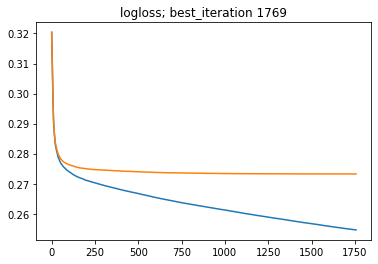

In [40]:
plt.plot(evalres['tr']['binary_logloss'])
plt.plot(evalres['vl']['binary_logloss'])
plt.title(f"logloss; best_iteration {bst.best_iteration}")
plt.show()

## model features

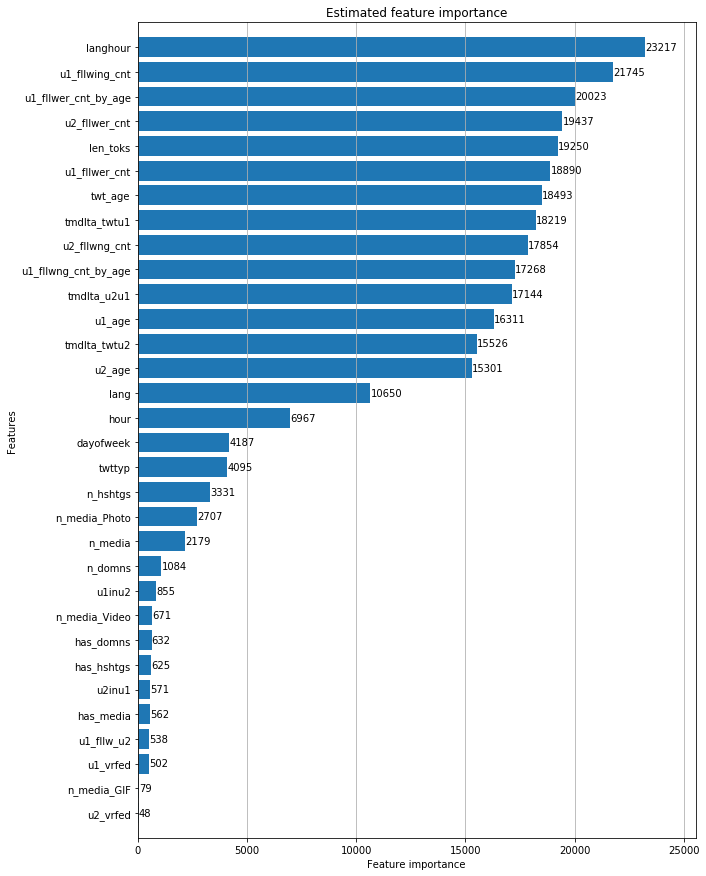

In [41]:
ax = lgb.plot_importance(bst, height=0.8, max_num_features=50, figsize=(10,15))
ax.grid(False, axis="y")
ax.set_title(f'Estimated feature importance')
plt.show()

In [42]:
pd.DataFrame([bst.feature_name(), bst.feature_importance()]).T.sort_values(1, ascending=False)

,0,1
31,langhour,23217
3,u1_fllwing_cnt,21745
29,u1_fllwer_cnt_by_age,20023
5,u2_fllwer_cnt,19437
11,len_toks,19250
2,u1_fllwer_cnt,18890
26,twt_age,18493
24,tmdlta_twtu1,18219
6,u2_fllwng_cnt,17854
30,u1_fllwng_cnt_by_age,17268


In [43]:
col2imp = dict(zip(bst.feature_name(), bst.feature_importance()))
sorted(col2imp.items(), key=lambda x: -x[1])

[('langhour', 23217),
 ('u1_fllwing_cnt', 21745),
 ('u1_fllwer_cnt_by_age', 20023),
 ('u2_fllwer_cnt', 19437),
 ('len_toks', 19250),
 ('u1_fllwer_cnt', 18890),
 ('twt_age', 18493),
 ('tmdlta_twtu1', 18219),
 ('u2_fllwng_cnt', 17854),
 ('u1_fllwng_cnt_by_age', 17268),
 ('tmdlta_u2u1', 17144),
 ('u1_age', 16311),
 ('tmdlta_twtu2', 15526),
 ('u2_age', 15301),
 ('lang', 10650),
 ('hour', 6967),
 ('dayofweek', 4187),
 ('twttyp', 4095),
 ('n_hshtgs', 3331),
 ('n_media_Photo', 2707),
 ('n_media', 2179),
 ('n_domns', 1084),
 ('u1inu2', 855),
 ('n_media_Video', 671),
 ('has_domns', 632),
 ('has_hshtgs', 625),
 ('u2inu1', 571),
 ('has_media', 562),
 ('u1_fllw_u2', 538),
 ('u1_vrfed', 502),
 ('n_media_GIF', 79),
 ('u2_vrfed', 48)]

In [44]:
[o[0] for o in sorted(col2imp.items(), key=lambda x: -x[1]) if o[1]>0]

['langhour',
 'u1_fllwing_cnt',
 'u1_fllwer_cnt_by_age',
 'u2_fllwer_cnt',
 'len_toks',
 'u1_fllwer_cnt',
 'twt_age',
 'tmdlta_twtu1',
 'u2_fllwng_cnt',
 'u1_fllwng_cnt_by_age',
 'tmdlta_u2u1',
 'u1_age',
 'tmdlta_twtu2',
 'u2_age',
 'lang',
 'hour',
 'dayofweek',
 'twttyp',
 'n_hshtgs',
 'n_media_Photo',
 'n_media',
 'n_domns',
 'u1inu2',
 'n_media_Video',
 'has_domns',
 'has_hshtgs',
 'u2inu1',
 'has_media',
 'u1_fllw_u2',
 'u1_vrfed',
 'n_media_GIF',
 'u2_vrfed']

# eval

In [ ]:
%%time
prdtr = bst.predict(dftr[cols_feat],num_iteration=bst.best_iteration)
prdvl = bst.predict(dfvl[cols_feat],num_iteration=bst.best_iteration)
prdval0 = bst.predict(dfval[cols_feat],num_iteration=bst.best_iteration)
prdval = calibration(prdval0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

In [ ]:
%%time
ytr,yvl,yval=[df[TCOL].values for df in (dftr,dfvl,dfval)]

auc_tr=compute_prauc(prdtr, ytr)
rce_tr=compute_rce(prdtr, ytr)
auc_vl=compute_prauc(prdvl, yvl)
rce_vl=compute_rce(prdvl, yvl)
auc_val=compute_prauc(prdval, yval)
rce_val=compute_rce(prdval, yval)

results['scrs'] = {}
results['scrs']['auc_tr']=auc_tr
results['scrs']['rce_tr']=rce_tr
results['scrs']['auc_vl']=auc_vl
results['scrs']['rce_vl']=rce_vl
results['scrs']['auc_val']=auc_val
results['scrs']['rce_val']=rce_val

In [38]:
print(f'auc_tr:  {auc_tr:.4f}')
print(f'auc_vl:  {auc_vl:.4f}')
print(f'auc_val: {auc_val:.4f}')
print()
print(f'rce_tr:  {rce_tr:.4f}')
print(f'rce_vl:  {rce_vl:.4f}')
print(f'rce_val: {rce_val:.4f}')

auc_tr:  0.4149
auc_vl:  0.3247
auc_val: 0.1178

rce_tr:  22.4319
rce_vl:  16.8343
rce_val: 13.0807


## score

In [37]:
print(f'-{auc_val:.4f}-{rce_val:.4f}')

-0.1178-13.0807


# save results

In [ ]:
pickle.dump(results, open(f'{p_out}/results_{PRFX}.p', 'wb'))

# infer

In [ ]:
results = pickle.load( open(f'{p_out}/results_{PRFX}.p', 'rb'))
bst = results['bst']
cols_feat = results['cols_feat']

## prep

In [ ]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{tsttmstmp}.tsv',
    sep='\x01', header=None, names=cols_val, 
#     nrows=10
)

In [ ]:
dftst.shape

In [ ]:
%%time
dftst=prp_df(dftst, tm_max=tm_tst_max)

In [ ]:
dftst.drop(columns=['u1id','u1u2'], inplace=True)
cols_category=['twttyp', 'lang', 'langhour']
dftst[cols_category]=dftst[cols_category].astype('category')

## predict

In [ ]:
%%time
prdtst0 = bst.predict(dftst[cols_feat],num_iteration=bst.best_iteration)
prdtst = calibration(prdtst0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

In [ ]:
dfsub_ids = dftst[['twtid','u2id',]]
dfsub = dfsub_ids.copy()
dfsub['scr'] = prdtst
dfsub.to_csv(f'{p_out}/{TGT}__{PRFX}.csv',index=False,header=False)